# Summary



# Intro

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from biodata import *

In [47]:
from az_dream import functions as fn

In [48]:
from common import dat

In [49]:
%matplotlib inline

# Prepare input

## d_1 / d_2 / c

In [50]:
GB_D = [
    'az_dream_2015.ALL_TRAINING_DATA_GBD',
    'cnv_gbd',
    'cnv_gbd_stitch',
    'gex_gbd',
    'gex_gbd_stitch',
    'methyl_gbd',
    'methyl_gbd_stitch',
    'mutations_gbd',
    'mutations_gbd_stitch',
    'achilles_rnai_gbd',
    'achilles_rnai_gbd_stitch',
    # Baseline network props
    'ppi_full_vertex_gbd',
    'string_full_vertex_gbd',
]

GB_DC = [
    'az_dream_2015.ALL_TRAINING_DATA_GBDC',
    'cnv_gbdc',
    'cnv_gbdc_stitch',
    'gex_gbdc',
    'gex_gbdc_stitch',
    'methyl_gbdc',
    'methyl_gbdc_stitch',
    'mutations_gbdc',
    'mutations_gbdc_stitch',
    'achilles_rnai_gbdc',
    'achilles_rnai_gbdc_stitch',
]

GB_DD = [
    'az_dream_2015.ALL_TRAINING_DATA_GBDD',
    'az_dream_2015_features.drug_pair_info_gbdd',
    'az_dream_2015_features.clare_gbdd',
    'az_dream_2015_features.clare_gbdd_stitch',
    # Gene serts
    'az_dream_2015_features.gsea_subset_gbdd',
    'az_dream_2015_features.gsea_subset_gbdd_stitch',
    # Baseline network props
    'ppi_full_edge_gbdd',
    'ppi_full_all_edge_gbdd',
    'string_full_edge_gbdd',
    'string_full_all_edge_gbdd',
]

GB_DDC = [
    # Baseline network props DELTA
]
    
GB_C = [
    'az_dream_2015.ALL_TRAINING_DATA_GBC',
    'cnv_gbc',
    'gex_gbc',
    'methyl_gbc',
    'mutations_gbc',
    'achilles_rnai_gbc',
]


In [51]:
engine = sa.create_engine("mysql://strokach:@192.168.6.19:3306/az_dream_2015_features")


def get_gbdd():
    features = []
    tables = []
    for whole_table_name in GB_DD:
        table_name = whole_table_name.split('.')[-1]
        features.append('-- {}'.format(table_name))
        tables.append("LEFT JOIN {0} {1} USING (d_1, d_2)".format(whole_table_name, table_name))
        # features.append('{}.*'.format(table_name))
        # instead...
        df = pd.read_sql_query("select * from {} limit 0".format(whole_table_name), engine)
        for column in df.columns:
            if column in ['d', 'd_1', 'd_2', 'g', 'g_1', 'g_2', 'c']:
                continue
            features.append("{0}.{1} {1}".format(table_name, column))
    return features, tables
    

def get_gbc():
    features = []
    tables = []
    for whole_table_name in GB_C:
        table_name = whole_table_name.split('.')[-1]
        features.append('-- {}'.format(table_name))
        tables.append("LEFT JOIN {0} {1} USING (c)".format(whole_table_name, table_name))
        # features.append('{}.*'.format(table_name))
        # instead...
        df = pd.read_sql_query("select * from {} limit 0".format(whole_table_name), engine)
        for column in df.columns:
            if column in ['d', 'd_1', 'd_2', 'g', 'g_1', 'g_2', 'c']:
                continue
            features.append("{0}.{1} {1}".format(table_name, column))
    return features, tables


def get_gbd():
    features = []
    tables = []
    for whole_table_name in GB_D:
        table_name = whole_table_name.split('.')[-1]
        features.append('-- {}'.format(table_name))
        tables.append("LEFT JOIN {0} {1}_1 ON ({1}_1.d = a.d_1)".format(whole_table_name, table_name))
        tables.append("LEFT JOIN {0} {1}_2 ON ({1}_2.d = a.d_2)".format(whole_table_name, table_name))
        #
        df = pd.read_sql_query("select * from {} limit 0".format(whole_table_name), engine)
        for column in df.columns:
            if column in ['d', 'd_1', 'd_2', 'g', 'g_1', 'g_2', 'c']:
                continue
            features.append("({0}_1.{1} + {0}_2.{1}) / 2 {1}_mean".format(table_name, column))
            features.append("abs({0}_2.{1} - {0}_1.{1}) {1}_diff".format(table_name, column))
    return features, tables

            
def get_gbdc():
    features = []
    tables = []
    for whole_table_name in GB_DC:
        table_name = whole_table_name.split('.')[-1]
        features.append('-- {}'.format(table_name))
        tables.append("LEFT JOIN {0} {1}_1 ON ({1}_1.d = a.d_1 AND {1}_1.c = a.c)".format(whole_table_name, table_name))
        tables.append("LEFT JOIN {0} {1}_2 ON ({1}_2.d = a.d_2 AND {1}_2.c = a.c)".format(whole_table_name, table_name))
        #
        df = pd.read_sql_query("select * from {} limit 0".format(whole_table_name), engine)
        for column in df.columns:
            if column in ['d', 'g', 'c']:
                continue
            features.append("({0}_1.{1} + {0}_2.{1}) / 2 {1}_mean".format(table_name, column))
            features.append("abs({0}_2.{1} - {0}_1.{1}) {1}_diff".format(table_name, column))
    return features, tables

In [52]:
sql_query = ""


sql_query += """
CREATE TEMPORARY TABLE gbdd as (
SELECT a.id,
{features}
FROM az_dream_2015.ALL_TRAINING_DATA_WSYNERGY a
{tables}
);
create index a on gbdd (id);


""".format(**{n: fn(v) for (n, fn, v) in zip(
    ['features', 'tables'], [lambda x: ",\n".join(x), lambda x: "\n".join(x)], get_gbdd())})


sql_query += """
CREATE TEMPORARY TABLE gbc as (
SELECT a.id,
{features}
FROM az_dream_2015.ALL_TRAINING_DATA_WSYNERGY a
{tables}
);
create index a on gbc (id);


""".format(**{n: fn(v) for (n, fn, v) in zip(
    ['features', 'tables'], [lambda x: ",\n".join(x), lambda x: "\n".join(x)], get_gbc())})


sql_query += """
CREATE TEMPORARY TABLE gbd as (
SELECT a.id,
{features}
FROM az_dream_2015.ALL_TRAINING_DATA_WSYNERGY a
{tables}
);
create index a on gbd (id);


""".format(**{n: fn(v) for (n, fn, v) in zip(
    ['features', 'tables'], [lambda x: ",\n".join(x), lambda x: "\n".join(x)], get_gbd())})


sql_query += """
CREATE TEMPORARY TABLE gbdc as (
SELECT a.id,
{features}
FROM az_dream_2015.ALL_TRAINING_DATA_WSYNERGY a
{tables}
);
create index a on gbdc (id);


""".format(**{n: fn(v) for (n, fn, v) in zip(
    ['features', 'tables'], [lambda x: ",\n".join(x), lambda x: "\n".join(x)], get_gbdc())})


sql_query += """
SELECT *
FROM az_dream_2015.ALL_TRAINING_DATA_WSYNERGY a
LEFT JOIN gbdd USING (id)
LEFT JOIN gbc USING (id)
LEFT JOIN gbd USING (id)
LEFT JOIN gbdc USING (id)
"""

with open('machine_learning/load_data.sql', 'wt') as ofh:
    ofh.write(sql_query)

In [53]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_2015_features')
subqueries = sql_query.strip(' ;').split(';')
for i, subquery in enumerate(subqueries[:-1]):
    print("Running subquery {}".format(i))
    engine.execute(subquery)
df = pd.read_sql_query(subqueries[-1], engine)

Running subquery 0
Running subquery 1
Running subquery 2
Running subquery 3
Running subquery 4
Running subquery 5
Running subquery 6
Running subquery 7


In [54]:
df_original = df.copy()

## Process

In [55]:
df = df_original.copy()

In [56]:
df.shape

(39284, 952)

In [57]:
print("Number of rows without qa (assuming 1): {:,d}".format(df['qa'].isnull().sum()))
df.loc[df['qa'].isnull(), 'qa'] = 1

Number of rows without qa (assuming 1): 27,709


In [58]:
# Remove bad quality
bad_qas = [-3, -2, -1]
df = df[~df['qa'].isin(bad_qas)]

In [59]:
df.shape

(38880, 952)

In [60]:
# Correct synergy scores
df.loc[df['synergy_score'] > 100, 'synergy_score'] = 100
df.loc[df['synergy_score'] < -100, 'synergy_score'] = -100

In [61]:
# Remove duplicate columns
seen = Counter()
keep_i = []
keep_name = []
for i, column in enumerate(df.columns):
    if column not in seen:
        seen.update([column])
        keep_i.append(i)
        keep_name.append(column)
    elif seen.get(column) == 1:
        print(column)
        seen.update([column])
        keep_i.append(i)
        keep_name.append(column + '_stitch')
    else:
        # Delete column
        print("\t", column)

df = df.iloc[:, keep_i]
df.columns = keep_name
df.head()

,id,c,d_1,d_2,synergy_score,qa,source,max_conc_mean,max_conc_diff,ic50_mean,ic50_diff,h_mean,h_diff,einf_mean,einf_diff,count_gbdd,max_conc_gbdd_min_mean,max_conc_gbdd_min_diff,max_conc_gbdd_max_mean,max_conc_gbdd_max_diff,max_conc_gbdd_mean_mean,max_conc_gbdd_mean_diff,max_conc_gbdd_std_mean,max_conc_gbdd_std_diff,ic50_gbdd_min_mean,ic50_gbdd_min_diff,ic50_gbdd_max_mean,ic50_gbdd_max_diff,ic50_gbdd_mean_mean,ic50_gbdd_mean_diff,ic50_gbdd_std_mean,ic50_gbdd_std_diff,h_gbdd_min_mean,h_gbdd_min_diff,h_gbdd_max_mean,h_gbdd_max_diff,h_gbdd_mean_mean,h_gbdd_mean_diff,h_gbdd_std_mean,h_gbdd_std_diff,einf_gbdd_min_mean,einf_gbdd_min_diff,einf_gbdd_max_mean,einf_gbdd_max_diff,einf_gbdd_mean_mean,einf_gbdd_mean_diff,einf_gbdd_std_mean,einf_gbdd_std_diff,hba_mean,hba_diff,c_log_p_mean,c_log_p_diff,hbd_mean,hbd_diff,lipinski_mean,lipinski_diff,mw_mean,mw_diff,atom_stereo_count_mean,atom_stereo_count_diff,bond_stereo_count_mean,bond_stereo_count_diff,complexity_mean,complexity_diff,conformer_count3_d_mean,conformer_count3_d_diff,conformer_model_rmsd3_d_mean,conformer_model_rmsd3_d_diff,covalent_unit_count_mean,covalent_unit_count_diff,defined_atom_stereo_count_mean,defined_atom_stereo_count_diff,defined_bond_stereo_count_mean,defined_bond_stereo_count_diff,effective_rotor_count3_d_mean,effective_rotor_count3_d_diff,exact_mass_mean,exact_mass_diff,feature_acceptor_count3_d_mean,feature_acceptor_count3_d_diff,feature_anion_count3_d_mean,feature_anion_count3_d_diff,feature_cation_count3_d_mean,feature_cation_count3_d_diff,feature_count3_d_mean,feature_count3_d_diff,feature_donor_count3_d_mean,feature_donor_count3_d_diff,feature_hydrophobe_count3_d_mean,feature_hydrophobe_count3_d_diff,feature_ring_count3_d_mean,feature_ring_count3_d_diff,h_bond_acceptor_count_mean,h_bond_acceptor_count_diff,h_bond_donor_count_mean,h_bond_donor_count_diff,heavy_atom_count_mean,heavy_atom_count_diff,molecular_weight_mean,molecular_weight_diff,monoisotopic_mass_mean,monoisotopic_mass_diff,rotatable_bond_count_mean,rotatable_bond_count_diff,tpsa_mean,tpsa_diff,undefined_atom_stereo_count_mean,undefined_atom_stereo_count_diff,volume3_d_mean,volume3_d_diff,x_log_p_mean,x_log_p_diff,x_steric_quadrupole3_d_mean,x_steric_quadrupole3_d_diff,y_steric_quadrupole3_d_mean,y_steric_quadrupole3_d_diff,z_steric_quadrupole3_d_mean,z_steric_quadrupole3_d_diff,RDKFingerprint_Tanimoto,RDKFingerprint_Dice,RDKFingerprint_Cosine,RDKFingerprint_Russel,RDKFingerprint_Kulczynski,RDKFingerprint_McConnaughey,FingerprintMol_Tanimoto,FingerprintMol_Dice,FingerprintMol_Cosine,FingerprintMol_Russel,FingerprintMol_Kulczynski,FingerprintMol_McConnaughey,MACCSkeys_Tanimoto,MACCSkeys_Dice,MACCSkeys_Cosine,MACCSkeys_Russel,MACCSkeys_Kulczynski,MACCSkeys_McConnaughey,AtomPairFingerprint_Tanimoto,AtomPairFingerprint_Dice,AtomPairFingerprint_Cosine,AtomPairFingerprint_Russel,AtomPairFingerprint_Kulczynski,AtomPairFingerprint_McConnaughey,TopologicalTorsionFingerprint_Tanimoto,TopologicalTorsionFingerprint_Dice,MorganFingerprintR2_Tanimoto,MorganFingerprintR2_Dice,MorganFingerprintR2withFeatures_Tanimoto,MorganFingerprintR2withFeatures_Dice,bg_degree_mean,bg_degree_max,bg_degree_min,bg_degree_std,bg_clustering_coef_mean,bg_clustering_coef_max,bg_clustering_coef_min,bg_clustering_coef_std,bg_betweenness_mean,bg_betweenness_max,bg_betweenness_min,bg_betweenness_std,bg_closeness_mean,bg_closeness_max,bg_closeness_min,bg_closeness_std,bg_neighbor_sharing_mean,bg_neighbor_sharing_max,bg_neighbor_sharing_min,bg_neighbor_sharing_std,bg_shortest_path_length_mean,bg_shortest_path_length_min,bg_eb_max_max,bg_eb_min_min,bg_eb_mean_mean,bg_eb_fraction_mean,bg_number_of_shortest_paths_mean,bg_number_of_shortest_paths_max,bg_number_of_shortest_paths_min,bg_number_of_shortest_paths_std,coexpression_mean,coexpression_max,coexpression_min,coexpression_std,gene_essentiality_max,gi_degree_mean,gi_degree_max,gi_degree_min,gi_degree_std,gi_clustering_coef_mean,gi_clustering_coef_max,gi_clustering_coef_min,gi_clustering_

## Fill null values

In [62]:
df.shape

(38880, 952)

In [63]:
# Remove columns with too many nulls
df_nulls = df.isnull().sum()
df_nulls[df_nulls > 0]

synergy_score                                         32624
max_conc_mean                                         27709
max_conc_diff                                         27709
ic50_mean                                             27709
ic50_diff                                             27709
h_mean                                                27709
h_diff                                                27709
einf_mean                                             27709
einf_diff                                             27709
count_gbdd                                               85
max_conc_gbdd_min_mean                                   85
max_conc_gbdd_min_diff                                   85
max_conc_gbdd_max_mean                                   85
max_conc_gbdd_max_diff                                   85
max_conc_gbdd_mean_mean                                  85
max_conc_gbdd_mean_diff                                  85
max_conc_gbdd_std_mean                  

In [64]:
zero_columns = [
    'go_',
    'msigdb_',
    'f_',
    'ppi_',
    'string_',
]

for c in df.columns:
    for prefix in zero_columns:
        if not c.startswith(prefix):
            continue
        df[c] = df[c].fillna(0)

In [65]:
df['missing_structure'] = (df['RDKFingerprint_Tanimoto'].isnull()).astype(int)

In [66]:
# Remove columns with too many nulls
df_nulls = df.isnull().sum()
df_nulls[df_nulls > 0]

synergy_score                                   32624
max_conc_mean                                   27709
max_conc_diff                                   27709
ic50_mean                                       27709
ic50_diff                                       27709
h_mean                                          27709
h_diff                                          27709
einf_mean                                       27709
einf_diff                                       27709
count_gbdd                                         85
max_conc_gbdd_min_mean                             85
max_conc_gbdd_min_diff                             85
max_conc_gbdd_max_mean                             85
max_conc_gbdd_max_diff                             85
max_conc_gbdd_mean_mean                            85
max_conc_gbdd_mean_diff                            85
max_conc_gbdd_std_mean                            341
max_conc_gbdd_std_diff                            341
ic50_gbdd_min_mean          

In [67]:
df.head()

,id,c,d_1,d_2,synergy_score,qa,source,max_conc_mean,max_conc_diff,ic50_mean,ic50_diff,h_mean,h_diff,einf_mean,einf_diff,count_gbdd,max_conc_gbdd_min_mean,max_conc_gbdd_min_diff,max_conc_gbdd_max_mean,max_conc_gbdd_max_diff,max_conc_gbdd_mean_mean,max_conc_gbdd_mean_diff,max_conc_gbdd_std_mean,max_conc_gbdd_std_diff,ic50_gbdd_min_mean,ic50_gbdd_min_diff,ic50_gbdd_max_mean,ic50_gbdd_max_diff,ic50_gbdd_mean_mean,ic50_gbdd_mean_diff,ic50_gbdd_std_mean,ic50_gbdd_std_diff,h_gbdd_min_mean,h_gbdd_min_diff,h_gbdd_max_mean,h_gbdd_max_diff,h_gbdd_mean_mean,h_gbdd_mean_diff,h_gbdd_std_mean,h_gbdd_std_diff,einf_gbdd_min_mean,einf_gbdd_min_diff,einf_gbdd_max_mean,einf_gbdd_max_diff,einf_gbdd_mean_mean,einf_gbdd_mean_diff,einf_gbdd_std_mean,einf_gbdd_std_diff,hba_mean,hba_diff,c_log_p_mean,c_log_p_diff,hbd_mean,hbd_diff,lipinski_mean,lipinski_diff,mw_mean,mw_diff,atom_stereo_count_mean,atom_stereo_count_diff,bond_stereo_count_mean,bond_stereo_count_diff,complexity_mean,complexity_diff,conformer_count3_d_mean,conformer_count3_d_diff,conformer_model_rmsd3_d_mean,conformer_model_rmsd3_d_diff,covalent_unit_count_mean,covalent_unit_count_diff,defined_atom_stereo_count_mean,defined_atom_stereo_count_diff,defined_bond_stereo_count_mean,defined_bond_stereo_count_diff,effective_rotor_count3_d_mean,effective_rotor_count3_d_diff,exact_mass_mean,exact_mass_diff,feature_acceptor_count3_d_mean,feature_acceptor_count3_d_diff,feature_anion_count3_d_mean,feature_anion_count3_d_diff,feature_cation_count3_d_mean,feature_cation_count3_d_diff,feature_count3_d_mean,feature_count3_d_diff,feature_donor_count3_d_mean,feature_donor_count3_d_diff,feature_hydrophobe_count3_d_mean,feature_hydrophobe_count3_d_diff,feature_ring_count3_d_mean,feature_ring_count3_d_diff,h_bond_acceptor_count_mean,h_bond_acceptor_count_diff,h_bond_donor_count_mean,h_bond_donor_count_diff,heavy_atom_count_mean,heavy_atom_count_diff,molecular_weight_mean,molecular_weight_diff,monoisotopic_mass_mean,monoisotopic_mass_diff,rotatable_bond_count_mean,rotatable_bond_count_diff,tpsa_mean,tpsa_diff,undefined_atom_stereo_count_mean,undefined_atom_stereo_count_diff,volume3_d_mean,volume3_d_diff,x_log_p_mean,x_log_p_diff,x_steric_quadrupole3_d_mean,x_steric_quadrupole3_d_diff,y_steric_quadrupole3_d_mean,y_steric_quadrupole3_d_diff,z_steric_quadrupole3_d_mean,z_steric_quadrupole3_d_diff,RDKFingerprint_Tanimoto,RDKFingerprint_Dice,RDKFingerprint_Cosine,RDKFingerprint_Russel,RDKFingerprint_Kulczynski,RDKFingerprint_McConnaughey,FingerprintMol_Tanimoto,FingerprintMol_Dice,FingerprintMol_Cosine,FingerprintMol_Russel,FingerprintMol_Kulczynski,FingerprintMol_McConnaughey,MACCSkeys_Tanimoto,MACCSkeys_Dice,MACCSkeys_Cosine,MACCSkeys_Russel,MACCSkeys_Kulczynski,MACCSkeys_McConnaughey,AtomPairFingerprint_Tanimoto,AtomPairFingerprint_Dice,AtomPairFingerprint_Cosine,AtomPairFingerprint_Russel,AtomPairFingerprint_Kulczynski,AtomPairFingerprint_McConnaughey,TopologicalTorsionFingerprint_Tanimoto,TopologicalTorsionFingerprint_Dice,MorganFingerprintR2_Tanimoto,MorganFingerprintR2_Dice,MorganFingerprintR2withFeatures_Tanimoto,MorganFingerprintR2withFeatures_Dice,bg_degree_mean,bg_degree_max,bg_degree_min,bg_degree_std,bg_clustering_coef_mean,bg_clustering_coef_max,bg_clustering_coef_min,bg_clustering_coef_std,bg_betweenness_mean,bg_betweenness_max,bg_betweenness_min,bg_betweenness_std,bg_closeness_mean,bg_closeness_max,bg_closeness_min,bg_closeness_std,bg_neighbor_sharing_mean,bg_neighbor_sharing_max,bg_neighbor_sharing_min,bg_neighbor_sharing_std,bg_shortest_path_length_mean,bg_shortest_path_length_min,bg_eb_max_max,bg_eb_min_min,bg_eb_mean_mean,bg_eb_fraction_mean,bg_number_of_shortest_paths_mean,bg_number_of_shortest_paths_max,bg_number_of_shortest_paths_min,bg_number_of_shortest_paths_std,coexpression_mean,coexpression_max,coexpression_min,coexpression_std,gene_essentiality_max,gi_degree_mean,gi_degree_max,gi_degree_min,gi_degree_std,gi_clustering_coef_mean,gi_clustering_coef_max,gi_clustering_coef_min,gi_clustering_

In [68]:
feature_columns = fn.get_feature_columns(df)

c
d_1
d_2
synergy_score
qa
source


## Impute

In [69]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

values_imputed = imputer.fit_transform(df[feature_columns].values)

In [70]:
df_imputed = pd.DataFrame(values_imputed, columns=feature_columns, index=df.index.copy())

id_columns = ['d_1', 'd_2', 'c', 'qa', 'synergy_score', 'source']
for c in id_columns:
    df_imputed[c] = df[c]
    
df_imputed = df_imputed.reindex_axis(id_columns + feature_columns, axis=1)

df_imputed.head()

,d_1,d_2,c,qa,synergy_score,source,id,max_conc_mean,max_conc_diff,ic50_mean,ic50_diff,h_mean,h_diff,einf_mean,einf_diff,count_gbdd,max_conc_gbdd_min_mean,max_conc_gbdd_min_diff,max_conc_gbdd_max_mean,max_conc_gbdd_max_diff,max_conc_gbdd_mean_mean,max_conc_gbdd_mean_diff,max_conc_gbdd_std_mean,max_conc_gbdd_std_diff,ic50_gbdd_min_mean,ic50_gbdd_min_diff,ic50_gbdd_max_mean,ic50_gbdd_max_diff,ic50_gbdd_mean_mean,ic50_gbdd_mean_diff,ic50_gbdd_std_mean,ic50_gbdd_std_diff,h_gbdd_min_mean,h_gbdd_min_diff,h_gbdd_max_mean,h_gbdd_max_diff,h_gbdd_mean_mean,h_gbdd_mean_diff,h_gbdd_std_mean,h_gbdd_std_diff,einf_gbdd_min_mean,einf_gbdd_min_diff,einf_gbdd_max_mean,einf_gbdd_max_diff,einf_gbdd_mean_mean,einf_gbdd_mean_diff,einf_gbdd_std_mean,einf_gbdd_std_diff,hba_mean,hba_diff,c_log_p_mean,c_log_p_diff,hbd_mean,hbd_diff,lipinski_mean,lipinski_diff,mw_mean,mw_diff,atom_stereo_count_mean,atom_stereo_count_diff,bond_stereo_count_mean,bond_stereo_count_diff,complexity_mean,complexity_diff,conformer_count3_d_mean,conformer_count3_d_diff,conformer_model_rmsd3_d_mean,conformer_model_rmsd3_d_diff,covalent_unit_count_mean,covalent_unit_count_diff,defined_atom_stereo_count_mean,defined_atom_stereo_count_diff,defined_bond_stereo_count_mean,defined_bond_stereo_count_diff,effective_rotor_count3_d_mean,effective_rotor_count3_d_diff,exact_mass_mean,exact_mass_diff,feature_acceptor_count3_d_mean,feature_acceptor_count3_d_diff,feature_anion_count3_d_mean,feature_anion_count3_d_diff,feature_cation_count3_d_mean,feature_cation_count3_d_diff,feature_count3_d_mean,feature_count3_d_diff,feature_donor_count3_d_mean,feature_donor_count3_d_diff,feature_hydrophobe_count3_d_mean,feature_hydrophobe_count3_d_diff,feature_ring_count3_d_mean,feature_ring_count3_d_diff,h_bond_acceptor_count_mean,h_bond_acceptor_count_diff,h_bond_donor_count_mean,h_bond_donor_count_diff,heavy_atom_count_mean,heavy_atom_count_diff,molecular_weight_mean,molecular_weight_diff,monoisotopic_mass_mean,monoisotopic_mass_diff,rotatable_bond_count_mean,rotatable_bond_count_diff,tpsa_mean,tpsa_diff,undefined_atom_stereo_count_mean,undefined_atom_stereo_count_diff,volume3_d_mean,volume3_d_diff,x_log_p_mean,x_log_p_diff,x_steric_quadrupole3_d_mean,x_steric_quadrupole3_d_diff,y_steric_quadrupole3_d_mean,y_steric_quadrupole3_d_diff,z_steric_quadrupole3_d_mean,z_steric_quadrupole3_d_diff,RDKFingerprint_Tanimoto,RDKFingerprint_Dice,RDKFingerprint_Cosine,RDKFingerprint_Russel,RDKFingerprint_Kulczynski,RDKFingerprint_McConnaughey,FingerprintMol_Tanimoto,FingerprintMol_Dice,FingerprintMol_Cosine,FingerprintMol_Russel,FingerprintMol_Kulczynski,FingerprintMol_McConnaughey,MACCSkeys_Tanimoto,MACCSkeys_Dice,MACCSkeys_Cosine,MACCSkeys_Russel,MACCSkeys_Kulczynski,MACCSkeys_McConnaughey,AtomPairFingerprint_Tanimoto,AtomPairFingerprint_Dice,AtomPairFingerprint_Cosine,AtomPairFingerprint_Russel,AtomPairFingerprint_Kulczynski,AtomPairFingerprint_McConnaughey,TopologicalTorsionFingerprint_Tanimoto,TopologicalTorsionFingerprint_Dice,MorganFingerprintR2_Tanimoto,MorganFingerprintR2_Dice,MorganFingerprintR2withFeatures_Tanimoto,MorganFingerprintR2withFeatures_Dice,bg_degree_mean,bg_degree_max,bg_degree_min,bg_degree_std,bg_clustering_coef_mean,bg_clustering_coef_max,bg_clustering_coef_min,bg_clustering_coef_std,bg_betweenness_mean,bg_betweenness_max,bg_betweenness_min,bg_betweenness_std,bg_closeness_mean,bg_closeness_max,bg_closeness_min,bg_closeness_std,bg_neighbor_sharing_mean,bg_neighbor_sharing_max,bg_neighbor_sharing_min,bg_neighbor_sharing_std,bg_shortest_path_length_mean,bg_shortest_path_length_min,bg_eb_max_max,bg_eb_min_min,bg_eb_mean_mean,bg_eb_fraction_mean,bg_number_of_shortest_paths_mean,bg_number_of_shortest_paths_max,bg_number_of_shortest_paths_min,bg_number_of_shortest_paths_std,coexpression_mean,coexpression_max,coexpression_min,coexpression_std,gene_essentiality_max,gi_degree_mean,gi_degree_max,gi_degree_min,gi_degree_std,gi_clustering_coef_mean,gi_clustering_coef_max,gi_clustering_coef_min,gi_clustering_

## Standardize

In [71]:
from sklearn.preprocessing import scale, robust_scale, maxabs_scale

In [72]:
values_scaled = robust_scale(df_imputed[feature_columns].values)
values_scaled = maxabs_scale(values_scaled)

In [73]:
df_scaled = pd.DataFrame(values_scaled, columns=feature_columns, index=df.index.copy())

id_columns = ['d_1', 'd_2', 'c', 'qa', 'synergy_score', 'source']
for c in id_columns:
    df_scaled[c] = df[c]
    
df_scaled = df_scaled.reindex_axis(id_columns + feature_columns, axis=1)

df_scaled.head()

,d_1,d_2,c,qa,synergy_score,source,id,max_conc_mean,max_conc_diff,ic50_mean,ic50_diff,h_mean,h_diff,einf_mean,einf_diff,count_gbdd,max_conc_gbdd_min_mean,max_conc_gbdd_min_diff,max_conc_gbdd_max_mean,max_conc_gbdd_max_diff,max_conc_gbdd_mean_mean,max_conc_gbdd_mean_diff,max_conc_gbdd_std_mean,max_conc_gbdd_std_diff,ic50_gbdd_min_mean,ic50_gbdd_min_diff,ic50_gbdd_max_mean,ic50_gbdd_max_diff,ic50_gbdd_mean_mean,ic50_gbdd_mean_diff,ic50_gbdd_std_mean,ic50_gbdd_std_diff,h_gbdd_min_mean,h_gbdd_min_diff,h_gbdd_max_mean,h_gbdd_max_diff,h_gbdd_mean_mean,h_gbdd_mean_diff,h_gbdd_std_mean,h_gbdd_std_diff,einf_gbdd_min_mean,einf_gbdd_min_diff,einf_gbdd_max_mean,einf_gbdd_max_diff,einf_gbdd_mean_mean,einf_gbdd_mean_diff,einf_gbdd_std_mean,einf_gbdd_std_diff,hba_mean,hba_diff,c_log_p_mean,c_log_p_diff,hbd_mean,hbd_diff,lipinski_mean,lipinski_diff,mw_mean,mw_diff,atom_stereo_count_mean,atom_stereo_count_diff,bond_stereo_count_mean,bond_stereo_count_diff,complexity_mean,complexity_diff,conformer_count3_d_mean,conformer_count3_d_diff,conformer_model_rmsd3_d_mean,conformer_model_rmsd3_d_diff,covalent_unit_count_mean,covalent_unit_count_diff,defined_atom_stereo_count_mean,defined_atom_stereo_count_diff,defined_bond_stereo_count_mean,defined_bond_stereo_count_diff,effective_rotor_count3_d_mean,effective_rotor_count3_d_diff,exact_mass_mean,exact_mass_diff,feature_acceptor_count3_d_mean,feature_acceptor_count3_d_diff,feature_anion_count3_d_mean,feature_anion_count3_d_diff,feature_cation_count3_d_mean,feature_cation_count3_d_diff,feature_count3_d_mean,feature_count3_d_diff,feature_donor_count3_d_mean,feature_donor_count3_d_diff,feature_hydrophobe_count3_d_mean,feature_hydrophobe_count3_d_diff,feature_ring_count3_d_mean,feature_ring_count3_d_diff,h_bond_acceptor_count_mean,h_bond_acceptor_count_diff,h_bond_donor_count_mean,h_bond_donor_count_diff,heavy_atom_count_mean,heavy_atom_count_diff,molecular_weight_mean,molecular_weight_diff,monoisotopic_mass_mean,monoisotopic_mass_diff,rotatable_bond_count_mean,rotatable_bond_count_diff,tpsa_mean,tpsa_diff,undefined_atom_stereo_count_mean,undefined_atom_stereo_count_diff,volume3_d_mean,volume3_d_diff,x_log_p_mean,x_log_p_diff,x_steric_quadrupole3_d_mean,x_steric_quadrupole3_d_diff,y_steric_quadrupole3_d_mean,y_steric_quadrupole3_d_diff,z_steric_quadrupole3_d_mean,z_steric_quadrupole3_d_diff,RDKFingerprint_Tanimoto,RDKFingerprint_Dice,RDKFingerprint_Cosine,RDKFingerprint_Russel,RDKFingerprint_Kulczynski,RDKFingerprint_McConnaughey,FingerprintMol_Tanimoto,FingerprintMol_Dice,FingerprintMol_Cosine,FingerprintMol_Russel,FingerprintMol_Kulczynski,FingerprintMol_McConnaughey,MACCSkeys_Tanimoto,MACCSkeys_Dice,MACCSkeys_Cosine,MACCSkeys_Russel,MACCSkeys_Kulczynski,MACCSkeys_McConnaughey,AtomPairFingerprint_Tanimoto,AtomPairFingerprint_Dice,AtomPairFingerprint_Cosine,AtomPairFingerprint_Russel,AtomPairFingerprint_Kulczynski,AtomPairFingerprint_McConnaughey,TopologicalTorsionFingerprint_Tanimoto,TopologicalTorsionFingerprint_Dice,MorganFingerprintR2_Tanimoto,MorganFingerprintR2_Dice,MorganFingerprintR2withFeatures_Tanimoto,MorganFingerprintR2withFeatures_Dice,bg_degree_mean,bg_degree_max,bg_degree_min,bg_degree_std,bg_clustering_coef_mean,bg_clustering_coef_max,bg_clustering_coef_min,bg_clustering_coef_std,bg_betweenness_mean,bg_betweenness_max,bg_betweenness_min,bg_betweenness_std,bg_closeness_mean,bg_closeness_max,bg_closeness_min,bg_closeness_std,bg_neighbor_sharing_mean,bg_neighbor_sharing_max,bg_neighbor_sharing_min,bg_neighbor_sharing_std,bg_shortest_path_length_mean,bg_shortest_path_length_min,bg_eb_max_max,bg_eb_min_min,bg_eb_mean_mean,bg_eb_fraction_mean,bg_number_of_shortest_paths_mean,bg_number_of_shortest_paths_max,bg_number_of_shortest_paths_min,bg_number_of_shortest_paths_std,coexpression_mean,coexpression_max,coexpression_min,coexpression_std,gene_essentiality_max,gi_degree_mean,gi_degree_max,gi_degree_min,gi_degree_std,gi_clustering_coef_mean,gi_clustering_coef_max,gi_clustering_coef_min,gi_clustering_

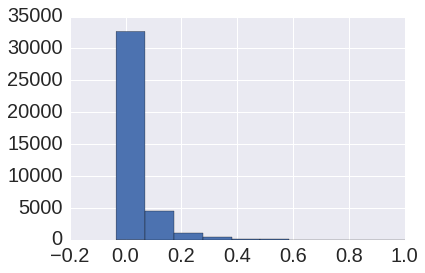

In [74]:
df_scaled['achilles_rnai_gs_gbgc_stitch_mean_diff'].hist()

## PCA

In [75]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA()

values_pca = pca.fit_transform(df_scaled[feature_columns].values)

(0, 300)

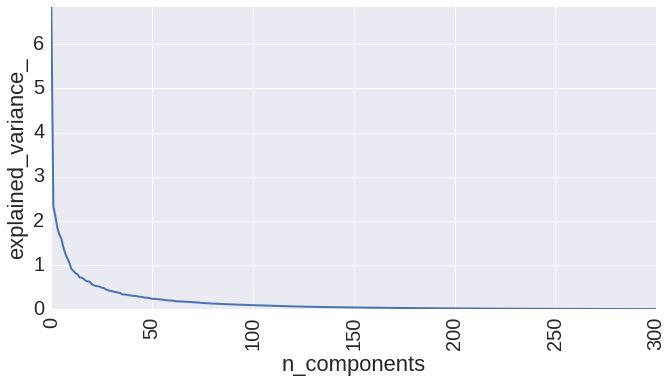

In [77]:
plt.figure(1, figsize=(12, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.xticks(rotation='vertical')
plt.xlim(0, 300)

In [78]:
df_pca = pd.DataFrame(values_pca, columns=list(range(values_pca.shape[1])), index=df.index.copy())

id_columns = ['d_1', 'd_2', 'c', 'qa', 'synergy_score', 'source']
for c in id_columns:
    df_pca[c] = df[c]
    
df_pca = df_pca.reindex_axis(id_columns + list(range(values_pca.shape[1])), axis=1)

df_pca.head()

,d_1,d_2,c,qa,synergy_score,source,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946
0,ADAM17,AKT,BT-20,1,29.540390,train,4.503040,-2.728566,1.010656,0.216599,2.438703,-0.547533,0.767490,-1.289041,1.661019,-0.280410,1.490552,0.028376,1.068339,0.546206,-0.703554,-1.038146,-0.195887,-0.840902,0.725366,0.136438,-0.280552,-0.913507,0.445308,1.243491,-0.417583,-0.217752,-0.6

In [79]:
df_pca.shape

(38880, 953)

In [80]:
tmp = df_pca[df_pca['synergy_score'].notnull()]

results = []
for i in range(values_pca.shape[1]):
    results.append(sp.stats.pearsonr(tmp[i], tmp['synergy_score']))
    
results_df = pd.DataFrame(results, columns=['corr', 'pvalue'])
results_df = results_df[results_df['pvalue'] < 0.001]
results_df['corr_abs'] = results_df['corr'].abs()
results_df.reset_index(inplace=True)
print(len(results_df))

125


In [81]:
results_df.head()

,index,corr,pvalue,corr_abs
0,0,-0.061436,1.156878e-06,0.061436
1,6,-0.080369,1.942850e-10,0.080369
2,7,0.091888,3.293348e-13,0.091888
3,8,0.125226,2.735662e-23,0.125226
4,11,-0.042948,6.792427e-04,0.042948


(-1e-06, 0.0001)

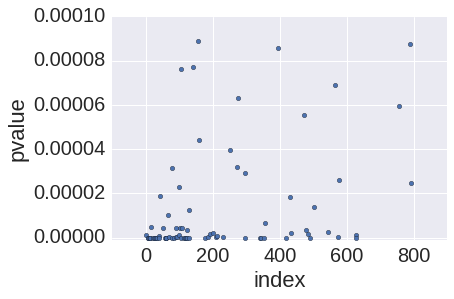

In [82]:
results_df.plot(x='index', y='pvalue', kind='scatter')
plt.ylim(-0.000001, 0.0001)

# Save

In [83]:
df_imputed.to_hdf(
    'machine_learning/ddc_data_imputed.h5',
    'ddc_data', mode='w', complevel=9, complib='blosc')

In [84]:
df_scaled.to_hdf(
    'machine_learning/ddc_data_scaled.h5',
    'ddc_data', mode='w', complevel=9, complib='blosc')

In [85]:
df_pca.to_hdf(
    'machine_learning/ddc_data_pca.h5',
    'ddc_data', mode='w', complevel=9, complib='blosc')

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/pandas/io/pytables.py:257: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/pandas/io/pytables.py:257: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_items] [items->None]

  f(store)
